# DL Reproducibility Project - Group 29


Paper: https://openreview.net/forum?id=-xjStp_F9o  
Data: https://github.com/mohakbhardwaj/motion_planning_datasets  
Report: https://www.overleaf.com/7161948885nydykbgkrsbq  


# Reproduction

In [1]:
import torch
import pathlib

In [2]:
# Run if using local storage

root_dir = pathlib.Path.cwd() / 'data'

In [3]:
# Run if using google drive

from google.colab import drive
drive.mount('/content/drive')
root_dir = 'drive/MyDrive/dl_reproducibility'

Mounted at /content/drive


In [4]:
root_path = pathlib.Path(root_dir)
experiment_path = root_path / 'experiments'
data_path = root_path / 'data'
mpdataset_path = data_path / 'motion_planning_datasets'
print('root:          ', root_path)
print('experiments:   ', experiment_path)
print('data:          ', data_path)
print('dataset:       ', mpdataset_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:        ', device)

root:           drive/MyDrive/dl_reproducibility
experiments:    drive/MyDrive/dl_reproducibility/experiments
data:           drive/MyDrive/dl_reproducibility/data
dataset:        drive/MyDrive/dl_reproducibility/data/motion_planning_datasets
device:         cpu


## Imports

<https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7>

In [5]:
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric
!pip install dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 29.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 58.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 19.0 MB/s eta 0:00:00
Looking in indexes: 

In [6]:
import torch.nn.functional as F
import torch_geometric

from torch.nn import GRU
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.utils.convert import from_networkx, to_networkx
from torch_geometric.nn.conv import GENConv
from torch_geometric.nn.models import Node2Vec
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.transforms import normalize_features

# Standard library
from copy import copy, deepcopy
from dataclasses import dataclass, field
from enum import Enum
from typing import Any, Callable, Iterator, Optional, Protocol, TypedDict, Union
import gc
import heapq
import itertools
import pathlib
# import pickle
import threading

# Third party libraries
from IPython import display
from matplotlib.ticker import MaxNLocator
import dill as pickle # better pickle
import imageio.v3 as iio
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pylab as pl

import psutil

## Parameters

In [7]:
# For proper intellisense
class Parameters(TypedDict):
    # GCN
    k_hop_neighborhood: int
    # GRU
    memory_embedding_dim: int
    num_memory_layers: int
    # MLP
    mlp_hidden_dim: int
    # Mixture policy / OracleControlelr
    beta: float
    # A* Runner
    max_neighborhood_size: int # n in the paper
    trajectory_length: int # T in the paper
    rollout_length: int # t_tau in the paper
    # Learner
    learning_rate: float
    # Experiment
    max_episodes: int # N in the paper
    num_trajectories: int # m in the paper
    patience: int # Early stopping
    patience_margin: int # Early stopping


def default_parameters() -> Parameters:
    return Parameters({
        # GCN
        'k_hop_neighborhood': 1, # From the PHIL paper section 4.1 on "Recurrent GNN Architecture"
        # GRU
        'memory_embedding_dim': 64, # From the PHIL paper section 5.1
        'num_memory_layers': 1, # Arbibrary choice, pytorch default is 1, not stated in the paper.
        # MLP
        'mlp_hidden_dim': 128, # From the PHIL paper section 5.1
        # Mixture policy / OracleControlelr
        'beta': 0.7, # From the PHIL paper section 5.1
        # A* Runner
        'max_neighborhood_size': 8, # From the PHIL paper section 5.1
        'trajectory_length': 128, # From the PHIL paper section 5.1
        'rollout_length': 32, # From the PHIL paper section 5.1
        # Learner
        'learning_rate': 1e-3, # From appendix C on optimization.
        # Experiment
        'max_episodes': 40, # section 5.1 states convergence after 36/200 iterations
        'num_trajectories': 1, # From the PHIL paper section 5.1
        'patience': 5,
        'patience_margin': 50,
    })

## Data Processing

### Unpack data zips

In [8]:
# Create root folder
if not root_path.exists():
    print('created root folder')
    root_path.mkdir(parents=True, exist_ok=True)

# Populate root folder with raw and processed data from data.zip
if root_path.exists() and pathlib.Path('data.zip').exists():
    print('Root path exists and data.zip exists')
    !unzip 'data.zip'

# Alternatively populate only with raw data.
if not mpdataset_path.exists() and pathlib.Path('motion_planning_datasets-master.zip').exists():
    print('populate with raw data')
    !unzip 'motion_planning_datasets-master.zip' -d 'data'
    (root_path / 'motion_planning_datasets-master').rename(mpdataset_path)

In [9]:
!zip -r 'data.zip' 'data'

	zip warning: name not matched: data

zip error: Nothing to do! (try: zip -r data.zip . -i data)


### Image file to graph
https://stackoverflow.com/a/63657018

Goal node is in the top right corner of the image.

**Node features** - Not given in the paper

- x position
- y position
- $h^*$ - shortest path distance to goal node (used for oracle, not for model)

**Edge features**

- None at the moment


FUTURE: move around goal_node as a it is very plausible the model overfits on the top-right corner. In some graphs it goes straight up and then right for a 100% success rate.

In [10]:
def node_name_from_pos(yx) -> tuple:
    return yx[0], yx[1]

def nodes_from_img(img: np.ndarray) -> list[tuple]:
    #Nodes and their x, y coordinates are read from an image
    # where white pixels correspond to nodes.
    return [(node_name_from_pos(yx), {'ypos': yx[0], 'xpos': yx[1]}) for yx in np.argwhere(img)]

def edges_from_img(img: np.ndarray) -> list[tuple[tuple, tuple]]:
    # Get all source pixels with vertical transitions from and to white pixels
    # from top to bottom and not wrapping around.
    vertical_sources = np.argwhere(img[:-1] & img[1:])
    # Targets are just those same pixels shifted 1 to the right.
    vertical_targets = vertical_sources + (1, 0)
    
    # Same trick horizontally, but now left to right
    horizontal_sources = np.argwhere(img[:,:-1] & img[:,1:])
    horizontal_targets = horizontal_sources + (0, 1)

    # Edges go by node name (source, target, weight)
    return list(zip(
        [node_name_from_pos(yx) for yx in np.vstack((vertical_sources, horizontal_sources))],
        [node_name_from_pos(yx) for yx in np.vstack((vertical_targets, horizontal_targets))],
        # [1 for _ in range(len(vertical_sources) + len(horizontal_sources))],
    ))

def goal_node_from_nx(graph: nx.Graph) -> tuple:
    # Goal node corresponds to the top-right pixel, assuming the pixel is white.
    # Top-right pixel will have y=0 and x=width-1
    return 0, max(x for (_, x) in graph.nodes(data='xpos'))

def source_node_from_nx(graph: nx.Graph):
    # Goal node corresponds to the bottom-left pixel, assuming the pixel is white.
    # Bottom-left pixel will have y=height-1 and x=0
    return max(y for (_, y) in graph.nodes(data='ypos')), 0

def image_to_nx(img: np.ndarray) -> nx.Graph:    
    graph = nx.Graph()
    graph.add_nodes_from(nodes_from_img(img))
    # Weighted edges add more data to the graph
    # and we currently do not use these edge features
    # graph.add_weighted_edges_from(edges_from_img(img))
    graph.add_edges_from(edges_from_img(img))

    ### Node attributes
    # degrees = dict(graph.degree())
    # nx.set_node_attributes(graph, degrees, 'degree')

    # Precompute the shortest paths to the goal.
    goal_node = goal_node_from_nx(graph)
    shortest_path_lengths_to_goal = nx.shortest_path_length(graph, target=goal_node)
    nx.set_node_attributes(graph, shortest_path_lengths_to_goal, 'y')

    # TODO: This is still a bit flawed as there are some graphs which are not
    # connected to the goal node causing a lot of the graph to be deleted.
    # It might be better to just set a multiple of the maximum pathlength.

    # Remove nodes which are disconnected from the goal.
    # These will not have a 'y' attribute set by the code above.
    # Not removing this will result in a non-homogeneous graph i.e. bad for pytorch data.
    graph.remove_nodes_from([node for node, y in graph.nodes(data='y') if y is None])
    
    return graph    

# img = np.array([[True, True], [True, False]])
# image_to_nx(img).nodes(data=True)

### Dataset

<https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html>  
<https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/data/dataset.html>  

`processed_paths` and `raw_paths` are generated by the `super().__init__` call

The x, y coordinates of the nodes will be concatenated into `data.x` and the oracle heuristic will be mapped to `data.y`.

In [11]:
class Datasets(Enum):
    ALTERNATING_GAPS  = 'alternating_gaps'
    BUGTRAP_FOREST    = 'bugtrap_forest'
    FOREST            = 'forest'
    GAPS_AND_FOREST   = 'gaps_and_forest'
    MAZES             = 'mazes'
    MULTIPLE_BUGTRAPS = 'multiple_bugtraps'
    SHIFTING_GAPS     = 'shifting_gaps'
    SINGLE_BUGTRAP    = 'single_bugtrap'

class MotionPlanningDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, name=Datasets.ALTERNATING_GAPS, split='train'):
        dir = pathlib.Path(root, name.value, split)
        assert dir.exists(), f'invalid directory: {dir}'

        self.root = str(dir.resolve())
        self._processed_dir = str(pathlib.Path(f'{root}_processed', name.value, split).resolve())
        self._raw_files = []
        self._processed_files = []
        self._load_file_names()

        super().__init__(self.root, transform, pre_transform, pre_filter)

    def _load_file_names(self):
        """Folder structure is as follows:
        root/motion_planning_dataset/bugtrap_forest/train"""
        paths = (entry.resolve() for entry in pathlib.Path(self.root).iterdir()
                 if entry.is_file())

        # Store only the filenames, not the full paths.
        for path in paths:
            self._raw_files.append(str(path.name))
            self._processed_files.append(str(path.with_suffix('.pt').name))

    @property
    def raw_file_names(self):
        return self._raw_files

    @property
    def processed_file_names(self):
        return self._processed_files
    
    @property
    def raw_dir(self):
        return self.root

    @property
    def processed_dir(self):
        return self._processed_dir

    def process(self):
        for (raw_path, processed_path) in zip(self.raw_paths, self.processed_paths):
            # Convert 8-bit color image to 1-bit black and white image
            img = iio.imread(raw_path) > 0
            graph = image_to_nx(img)
            # Concatenate both xpos and ypos into one attribute data.x
            # data.x contains node features
            # data.y contains shortest distance to top right / goal node.
            data = from_networkx(graph, group_node_attrs=['xpos', 'ypos'])

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, processed_path)
            gc.collect()

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx: int) -> torch_geometric.data.Data:
        data = torch.load(self.processed_paths[idx])
        return data

In [12]:
# Data from img_to_nx gives integers
def cast_to_float(data: Data):
    data.x = data.x.to(torch.float32)
    data.y = data.y.to(torch.float32)
    return data

alternating_gaps_train = MotionPlanningDataset(mpdataset_path, name=Datasets.ALTERNATING_GAPS, pre_transform=cast_to_float, split='train')
alternating_gaps_validation = MotionPlanningDataset(mpdataset_path, name=Datasets.ALTERNATING_GAPS, pre_transform=cast_to_float, split='validation')
alternating_gaps_test = MotionPlanningDataset(mpdataset_path, name=Datasets.ALTERNATING_GAPS, pre_transform=cast_to_float, split='test')

bugtrap_forest_train = MotionPlanningDataset(mpdataset_path, name=Datasets.BUGTRAP_FOREST, pre_transform=cast_to_float, split='train')
bugtrap_forest_validation = MotionPlanningDataset(mpdataset_path, name=Datasets.BUGTRAP_FOREST, pre_transform=cast_to_float, split='validation')
bugtrap_forest_test = MotionPlanningDataset(mpdataset_path, name=Datasets.BUGTRAP_FOREST, pre_transform=cast_to_float, split='test')

gaps_and_forest_train = MotionPlanningDataset(mpdataset_path, name=Datasets.GAPS_AND_FOREST, pre_transform=cast_to_float, split='train')
gaps_and_forest_validation = MotionPlanningDataset(mpdataset_path, name=Datasets.GAPS_AND_FOREST, pre_transform=cast_to_float, split='validation')
gaps_and_forest_test = MotionPlanningDataset(mpdataset_path, name=Datasets.GAPS_AND_FOREST, pre_transform=cast_to_float, split='test')

## Network Architecture

### Node embedding function
Projects the features of the current node (i) and the goal node into an embedding space, using Euclidean distance and Cosine distance metrics.

In the paper this is $f(x_i, x_g, D_{EUC}(x_i, x_g), D_{COS}(x_i, x_g))$

<https://towardsdatascience.com/node-embeddings-for-beginners-554ab1625d98>  
Node2Vec <https://arxiv.org/abs/1607.00653>  

Notes:
Author said nothing about which node features were used. However, the choice of features seems to be important for the node representation learning, as the network needs good features to determine 'closeness' of nodes. (as per node2vec paper)

Embedding works via representation learning, where we map the higher dimensional features into a lower dimensional space via a shallow network. Over time the network will learn better representations.

### Heuristic Function

Objective: train a heuristic metric $h_0: \Psi \times \mathcal{V}\times \mathcal{V} \rightarrow \mathbb{R}$ to predict node distances.  
Where $\Psi$ denotes the current history, the first $\mathcal{V}$ denotes $v \in OPEN$ and the second $\mathcal{V}$ denotes $v \in CLOSED$

The author then splits up the history into two components, a memory digest component $z_t$ which is an embedding of $\Psi$ at time $t$ and the observation history $\mathcal{O}$ giving us $h_0: \mathbb{R}^d \times \mathcal{O} \times \mathcal{V}\times \mathcal{V} \rightarrow \mathbb{R}$, where $d$ is the dimensionality of the embedding space. This allows the network automatically extract relevant features from the history as opposed to using the full history all the time.

In [13]:
class HeuristicFunction(torch.nn.Module):
    """Implements Algorithm 2 from the paper."""
    def __init__(
        self,
        num_node_features: int,
        params: Parameters,
        # node_feature_encoder = None,
        node_embedder = None,
        gcn = None,
        gru = None,
        mlp = None,
    ):
        super().__init__()

        # Network parameters
        self._num_node_features = num_node_features
        # x_i features + x_goal features + dist_euclidean + dist_cosine.
        self._num_embedded_node_features = 2 * num_node_features + 2
        # GCN
        self._k_hop_neighborhood = params['k_hop_neighborhood']
        # GRU
        self._memory_embedding_dim = params['memory_embedding_dim']
        self._num_memory_layers = params['num_memory_layers']
        # MLP
        self._mlp_hidden_dim = params['mlp_hidden_dim']

        # Network modules
        # self._node_feature_encoder = node_feature_encoder
        self._node_embedder = node_embedder
        self._gcn = gcn
        self._gru = gru
        self._mlp = mlp

        # Use torch_geometric.nn.Node2Vec
        # Does not work as the edge_index changes per graph.
        # if node_feature_encoder is None:
        #     self._node_feature_encoder = Node2Vec(
        #         edge_index,
        #         embedding_dim=num_node_features,
        #         walk_length=walk_length,
        #         context_size=context_size,
        #         walks_per_node=walks_per_node
        #     )

        # Shallow network
        if node_embedder is None:
            self._node_embedder = torch.nn.Linear(
                self._num_embedded_node_features,
                self._num_embedded_node_features,
            )

        # DeeperGCN
        if gcn is None:
            self._gcn = GENConv(
                in_channels=self._num_embedded_node_features,
                out_channels=self._num_embedded_node_features,
                aggr='softmax',
            )
        
        # GRU Notes:
        # Nothing is said about the number of hidden layers
        # The paper also does not mention how it takes the "sample mean"
        # over the memory state. Taking the sample mean is impossible without 
        # changing the shape of the memory state. Batching and then taking the mean
        # is also not possible since we then also have to give a batched input memory.
        # The only way to hack it is by duplicating the memory state to the correct batch size
        # then doing a batched GRU pass and calculating the mean of the batch.
        if gru is None:
            self._gru = GRU(
                input_size=self._num_embedded_node_features,
                hidden_size=self._memory_embedding_dim,
                num_layers=self._num_memory_layers,
            )

        # Multi Layer Perceptron
        if mlp is None:
            self._mlp = torch.nn.Sequential(
                # x_goal features + g' features.
                torch.nn.Linear(self._num_node_features + self._memory_embedding_dim, self._mlp_hidden_dim), torch.nn.LeakyReLU(),
                torch.nn.Linear(self._mlp_hidden_dim, self._mlp_hidden_dim), torch.nn.LeakyReLU(),
                torch.nn.Linear(self._mlp_hidden_dim, self._mlp_hidden_dim), torch.nn.LeakyReLU(),
                torch.nn.Linear(self._mlp_hidden_dim, self._mlp_hidden_dim), torch.nn.LeakyReLU(),
                # Output layer - outputs the scalar distance metric
                torch.nn.Linear(self._mlp_hidden_dim, 1),
            )


    def _get_encoded_node_features(self, x: torch.Tensor, goal: torch.Tensor) -> torch.Tensor:
        """Returns the encoded node features as well as the euclidean and cosine distances."""
        # Keepdim and unsqueeze make the output shape (N) -> (N,1)
        # so that we can concatenate them along dim 1 in the return value.
        dist_euclidean = F.pairwise_distance(x, goal, p=2).unsqueeze(dim=1)
        dist_cosine = F.cosine_similarity(x, goal, dim=1).unsqueeze(dim=1)

        # Use cat, not stack as stack creates an extra dimension.
        # Concatenate the features width wise (N, D1) + (N, D2) = (N, D1 + D2)
        return torch.cat((x, goal, dist_euclidean, dist_cosine), dim=1)

    def generate_memory(self, graph=None) -> torch.Tensor:
        """Generates randomly initialized memory.
        See: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html"""
        # return torch.randn((self._num_memory_layers, graph.x.shape[0], self._memory_embedding_dim))
        return torch.randn((self._num_memory_layers, self._memory_embedding_dim))

    def forward(
        self,
        graph: Data,
        node_index: torch.LongTensor,
        goal_index: torch.LongTensor,
        memory: torch.Tensor,
    ):
        """
        Steps:
        - Project nodes all into embedding space using embed_node(x_i, x_g, D_euc, D_cos)
        - Obtain g_i by doing a single graph convolution on x_i
        - Obtain hidden states z_i,t+1 and new embedding g'_i using GRU(g_i, z_t)
        - Take mean over the nodes in node_index in z_i,t+1 to get z_t+1
        - Get distance metric h from MLP(g'_i, x_g) and using the node index to get the actual nodes.
        """
        # Repeat the goal index for every node in the graph.
        goal_index = goal_index.repeat(graph.num_nodes)
        # We encode all nodes and then use the edge_index to define the 1-hop neighborhood
        x = self._get_encoded_node_features(graph.x, graph.x[goal_index].clone())
        x = self._node_embedder(x)
        x = F.leaky_relu(x)

        # Perform k-hop neighborhood aggregation.
        for _ in range(self._k_hop_neighborhood):
            x = self._gcn(x, graph.edge_index)
            x = F.leaky_relu(x)

        x = x[node_index]
        # To be able to take the sample mean over the gru, we have to "batch"
        # the input so we can then take the mean over that batch dimension,
        # once again giving use the correct memory shape.
        # Shape (D, H_out) -> (D, 1, H_out) -> (D, N, H_out)
        memory = memory.unsqueeze(1).repeat((1, node_index.shape[0], 1))
        x, memory = self._gru(x.unsqueeze(0), memory)
        x = F.leaky_relu(x.squeeze(0))
        # Take the mean over the nodes in the open set
        memory = torch.mean(memory, dim=1)

        # Concatenate the features width-wise: (N, D1) + (N, D2) -> (N, D1 + D2)
        x_goal = graph.x[goal_index[node_index]].clone()
        h = self._mlp(torch.cat((x, x_goal), dim=1))
        h = F.leaky_relu(h)

        return h, memory

## Euclidean distance function
Callable function that's just normal euclidean distance, done so that we can actually use A*

In [14]:
class euclidean_distance_func():
  def __init__(self):
    # Nothing to initialize so...
    pass

  def __call__(self, graph: Data, node_index: torch.LongTensor, goal_index: torch.LongTensor, memory) -> tuple([list, None]):
    """Given the graph and the corresponding fringe_set, returns the euclidean
    distances between the nodes and the target node.
    
    Memory is going to remain empty for now? It's just a leftover value from other
    stuff, that isn't really relevant for our needs"""

    goal_index = goal_index.repeat(graph.num_nodes)

    x = torch.norm(graph.x[node_index] - graph.x[goal_index], 2)
    x_goal = graph.x[goal_index[node_index]].clone()

    h = torch.cat((x, x_goal), dim=1)

    return h, None

  def eval() -> None:
    # Leftover function for compatability with other stuff
    pass

  def generate_memory(self, graph=None) -> torch.Tensor:
    # Leftover stuff for compatibility!
    return torch.randn((4, 2))

#heuristic_func(self.graph, fringe_set)

## Training architecture

1. Should sample a random graph $\mathcal{G}$ and a search problem $(v_s, v_g)$
1. Use greedy policy induced by $h_0$ to do roll-ins for $t \sim \mathcal{U}(0, ..., T - t_\tau)$  
where $T$ is the episode time horizon, and $t_\tau$ is the max roll-out length.
1. From roll-in obtain new state $s = (CLOSE^0, OPEN^0, REST^0)$ and initial memory state $z_t$


See Algorithm 1 from the paper

### Priority Queue

We need a priority queue for the A* algorithm. The default python implementation does not give us the ability to delete a specific element or to lazily delete an item (which is faster than deleting it).

Code partly sourced from <https://docs.python.org/3/library/heapq.html#priority-queue-implementation-notes>

In [15]:
# Order creates comparison dunder methods
@dataclass(order=True)
class PrioritizedItem:
    priority: float
    item: Any=field(compare=False)

class PriorityQueue:
    def __init__(self):
        self._priority_queue: list[PrioritizedItem] = []
        self._entry_finder: dict[Any, PrioritizedItem] = {}

    def enqueue(self, item: Any, priority=0) -> None:
        """Add a new entry or update the priority of an existing entry"""
        if item in self._entry_finder:
            self.remove(item)

        entry = PrioritizedItem(priority, item)
        self._entry_finder[item] = entry
        heapq.heappush(self._priority_queue, entry)

    def dequeue(self) -> Any:
        """Remove and return the lowest priority item. Raise KeyError if empty."""
        while self._priority_queue:
            entry = heapq.heappop(self._priority_queue)

            if entry.item is not None:
                del self._entry_finder[entry.item]
                return entry.item
        
        raise KeyError('pop from an empty priority queue')

    def remove(self, item: Any) -> None:
        """Mark an existing entry as removed."""
        entry = self._entry_finder.pop(item)
        entry.item = None    

### Trajectory Database

Stores all the trajectories and allows us to loop over them.

In [16]:
class Trajectory:
    fringe_sets: torch.LongTensor
    rollin_memory: torch.Tensor

    def __init__(self, fringe_size: int, rollin_memory, device='cpu'):
        self._lock = threading.Lock()
        self.rollin_memory = rollin_memory
        self.fringe_sets = []
        self._device = device

    # For pickling, as threading.lock is unpickleable.
    def __getstate__(self):
        return {
            'rollin_memory': self.rollin_memory,
            'fringe_sets': self.fringe_sets,
            'device': self._device
        }

    def __setstate__(self, state):
        self.rollin_memory = state['rollin_memory']
        self.fringe_sets = state['fringe_sets']
        self._device = state['device']
        self._lock = threading.Lock()

    def _diff_node_indices(self, fringe_set: torch.LongTensor, prev_fringe_set: torch.LongTensor) -> torch.LongTensor:
        """Returns the set difference of two index tensors, fringe_set - prev_node_index."""
        mask = torch.zeros((max(fringe_set.max().item(), prev_fringe_set.max().item()) + 1), dtype=torch.bool)
        mask[fringe_set] = True
        mask[prev_fringe_set] = False
        return mask.nonzero().flatten()
    
    def add(self, fringe_set: torch.LongTensor):
        """Adds the new fringe set to the trajectory and automatically
        calculates the difference with the previous fringe set."""
        self._lock.acquire()
        try:
            if fringe_set.numel() == 0:
                return self

            # Take the difference of the two fringe sets as stated in the paper
            if len(self.fringe_sets) > 0:
                prev_fringe_set = self.fringe_sets[-1]
                fringe_set = self._diff_node_indices(fringe_set, prev_fringe_set)

            self.fringe_sets.append(fringe_set.to(self._device))
        finally: self._lock.release()
        return self
    

class TrajectoryDatabase:
    def __init__(self):
        self._lock = threading.Lock()
        self._size = 0
        self._indices = [] # For iterating over the database.
        self._dict: dict[int, list[Trajectory]] = {}

    # For pickling, as threading.lock is unpickleable.
    def __getstate__(self):
        return {
            'size': self._size,
            'indices': self._indices,
            'dict': self._dict
        }

    def __setstate__(self, state):
        self._size = state['size']
        self._indices = state['indices']
        self._dict = state['dict']
        print('self state', state)
        self._lock = threading.Lock()

    @property
    def dict(self):
        return self._dict
    
    def add(self, graph_id: int, trajectory: Trajectory):
        """Add a trajectory to a graph."""
        self._lock.acquire()
        
        try:
            self._dict[graph_id] = self._dict.get(graph_id, [])
            self._dict[graph_id].append(trajectory)
            self._size += 1
        finally: self._lock.release()
        return self

    def __len__(self): 
        """Returns the length of the buffer."""
        return self._size
    
    def __iter__(self):  
        """Initializes an iterator over the buffer."""
        self._indices = list(self._dict.keys())
        return self
    
    def __next__(self):  
        """Iterates through the graphs in the database, returns list of trajectories."""
        if len(self._indices) == 0: raise StopIteration
        graph_id = self._indices[-1]
        self._indices = self._indices[:-1]
        return graph_id, self._dict[graph_id]


### Sampling the environment

Source nodes can be sampled randomly or fixed from the bottom-left corner.

Goal nodes are always in the top-right most position.

Graphs have their features normalized to prevent the gradients exploding in the GRU :)

In [17]:
@dataclass
class GraphInformation:
    graph: Data
    source_index: torch.LongTensor
    goal_index: torch.LongTensor

def sample_source_node(graph: Data, random=False, device='cpu') -> torch.LongTensor:
    """Samples a source node from the graph.
    if random=False then the bottom left node is chosen."""
    
    if random:
        return torch.tensor([np.random.randint(graph.x.shape[0])], dtype=torch.long, device=device)

    # Compute the minimum value of the x coordinate
    # and the maximum value of the y coordinate
    # to get the bottom-left corner of the graph.
    min_x = torch.min(graph.x[:, 0])
    max_y = torch.max(graph.x[:, 1])

    # Get the indices of nodes that have the maximum x coordinate and the minimum y coordinate
    min_x_indices = (graph.x[:, 0] == min_x).nonzero(as_tuple=True)[0].tolist()
    max_y_indices = (graph.x[:, 1] == max_y).nonzero(as_tuple=True)[0].tolist()

    # Return the first item of intersection of the two sets of indices
    return torch.as_tensor(list(set(min_x_indices) & set(max_y_indices))[:1], dtype=torch.long, device=device)

def sample_goal_node(graph: Data, device='cpu') -> torch.LongTensor:
    """Gets the top-right node from the graph."""
    # Compute the maximum value of the x coordinate
    # and the minimum value of the y coordinate
    # to get the top-right corner of the graph.
    max_x = torch.max(graph.x[:, 0])
    min_y = torch.min(graph.x[:, 1])

    # Get the indices of nodes that have the maximum x coordinate and the minimum y coordinate
    max_x_indices = (graph.x[:, 0] == max_x).nonzero(as_tuple=True)[0].tolist()
    min_y_indices = (graph.x[:, 1] == min_y).nonzero(as_tuple=True)[0].tolist()

    # Return the first item of intersection of the two sets of indices
    return torch.as_tensor(list(set(max_x_indices) & set(min_y_indices))[:1], dtype=torch.long, device=device)

def sample_graph_information(graph: Data, random=False, device='cpu') -> GraphInformation:
    # Source and goal node have to be found before normalization, or else
    #  the normalization screws up the definition of what it should be
    source_node = sample_source_node(graph, random=random, device=device)
    goal_node = sample_goal_node(graph, device=device)
    graph = normalize_features.NormalizeFeatures()(graph.clone()).to(device)
    return GraphInformation(
        graph,
        source_node,
        goal_node,
    )

### A* environment

An A* environment containing a variable amount of heuristic functions to use.

In [18]:
class AStarEnvironment:
    def __init__(self, heuristics: dict[str, Callable], params: Parameters):
        """An A* environment containing a variable amount of heuristic functions to use.
        heuristics: dict[name, heuristic(graph, node_index) -> torch.Tensor]
        """
        self._heuristics = heuristics
        self._max_neighborhood_size = params['max_neighborhood_size']

    def reset(self, graph: Data, source_index: torch.LongTensor, goal_index: torch.LongTensor):
        self.graph = graph
        self.source_index = source_index
        self.goal_index = goal_index
        self._queues = {name: PriorityQueue() for name in self._heuristics.keys()}
        self._g_scores = {name: {} for name in self._heuristics.keys()}
        self._f_scores = {name: {} for name in self._heuristics.keys()}
        self.closed_set = set()

        # Seed the environment with an initial value.
        for name, heuristic_func in self._heuristics.items():
            # Index tensor value is used as priority queue hash
            hash = source_index.item()
            f_score = heuristic_func(graph, source_index)
            self._g_scores[name][hash] = 0
            self._f_scores[name][hash] = f_score
            self._queues[name].enqueue(hash, f_score)

    def _get_node_by_heuristic(self, heuristic: str) -> int:
        """Pops one item from the specified queues and removes
        it from the other queues.
        
        Returns: the node index stored inside."""
        node_index = self._queues[heuristic].dequeue()

        for name, queue in self._queues.items():
            if name == heuristic:
                continue

            queue.remove(node_index)

        return node_index

    def _get_open_neighbors(self, node_index: int) -> torch.LongTensor:
        neighborhood_index = k_hop_subgraph(node_index, 1, self.graph.edge_index)[0]
        # Select the open nodes from the neighborhood
        fringe_set_mask = [neighbor.item() not in self.closed_set
                           for neighbor in neighborhood_index]
        fringe_set = neighborhood_index[fringe_set_mask]
        # Uniformly select at most n nodes from the neighborhood.
        random_mask = torch.randperm(fringe_set.shape[0])
        random_mask = random_mask[:self._max_neighborhood_size]
        return fringe_set[random_mask]

    def run(self, heuristic) -> tuple[torch.LongTensor, bool]:
        """Runs one step of the environment and updates internal bookkeeping.
        
        Returns: fringe set, done"""
        node_index = self._get_node_by_heuristic(heuristic)
        self.closed_set.add(node_index)
        fringe_set = self._get_open_neighbors(node_index)

        # Found the goal node
        if node_index == self.goal_index.item():
            return fringe_set, True

        if len(fringe_set) == 0:
            return fringe_set, False

        for name, heuristic_func in self._heuristics.items():
            # Get datastructures corresponding to current heuristic.
            heuristics = heuristic_func(self.graph, fringe_set)
            g_scores = self._g_scores[name]
            f_scores = self._f_scores[name]
            queue = self._queues[name]
            
            # Add open nodes according to A* rules.
            for index, heuristic in zip(fringe_set, heuristics):
                # Euclidean distance seems most popular for distance between nodes.
                dist = torch.norm(self.graph.x[node_index] - self.graph.x[index], 2).item()
                # Calculate new scores
                g_score = g_scores[node_index] + dist
                f_score = g_score + heuristic.item()

                # We cannot use tensors as hash, as they are hashed by id not value.
                hash = index.item()

                # Update state for heuristic queue
                if hash not in g_scores or g_score < g_scores[hash]:
                    self._g_scores[name][hash] = g_score
                    self._f_scores[name][hash] = f_score
                    self._queues[name].enqueue(hash, f_score)

        return fringe_set, False

### Controller
A controller selects an action for the runner and handles all the interations with the model.

In [19]:
class Controller(Protocol):
    """A controller selects an action for the runner
    and handles all the interations with the model."""
    def choose(self, **kwargs) -> Any:
        ...

#### Oracle Controller
Stochasitcally selects a queue to choose from to execute the mixture policy, and handles the heuristic value computation.

In [20]:
class OracleController:
    def __init__(self, model, actions: list[str], params: Parameters, device='cpu'):
        """Selects the mixture policy of PHIL during training.
    and handles all the interations with the model."""
        self._beta = params['beta']
        self._model = model
        self._heuristic = actions[0]
        self._oracle = actions[1]
        self._device = device

    # Used in the A* environment
    @property
    def heuristics(self):
        return {
            self._heuristic: self.heuristic,
            self._oracle: self.oracle,
        }

    def reset(self, goal_index):
        self._goal_index = goal_index
        self.memory = self._model.generate_memory().to(self._device)

    def set_beta(self, beta: float) -> None:
        self._beta = beta

    def heuristic(self, graph: Data, node_index: torch.LongTensor) -> torch.FloatTensor:
        heuristic, self.memory = self._model(graph, node_index, self._goal_index, self.memory)
        return heuristic

    def oracle(self, graph: Data, node_index: torch.LongTensor) -> torch.FloatTensor:
        return graph.y[node_index]

    def choose(self, rollin=False) -> Any:
        """Executes the mixture policy by stochastically choosing
        between the two heuristics."""
        if rollin or np.random.rand() > self._beta:
            return self._heuristic

        return self._oracle

### Runner

Does the roll outs, interacts with the environment, and collects the transition batches.

In [21]:
class Runner(Protocol):
    def run(self) -> dict:
        ...

#### A* Runner
Warms up the environment by first doing a roll-in, after which a roll-out is collected. Only the roll-out is collected as the roll-in is discarded during truncated backpropagation through time (TBTT)

In [22]:
class AStarRunner:
    def __init__(
        self,
        controller: Controller,
        params: Parameters,
        device='cpu',
    ):
        """A single threaded runner for the A* environment."""
        self._controller = controller
        self._env = AStarEnvironment(controller.heuristics, params)
        self._device = device

        # Hyper parameters
        self._max_neighborhood_size = params['max_neighborhood_size']
        self._trajectory_length = params['trajectory_length']
        self._rollout_length = params['rollout_length']

    def _reset_state(self, graph: GraphInformation):
        # Release resources as we do not need the current memory anymore.
        self._controller.reset(graph.goal_index)
        self._env.reset(graph.graph, graph.source_index, graph.goal_index)

    def _run_step(self, rollin=False) -> tuple[torch.LongTensor, bool]:
        """Runs a single step of the A* algorithm while updating the environment.
        Returns the new fringe mask, and whether the environment is done."""
        heuristic = self._controller.choose(rollin=rollin)
        return self._env.run(heuristic)

    @torch.no_grad()
    def run(self, graph: GraphInformation) -> dict:
        """Collects a single trajectory from the environment.
        Returns a dictionary containing the trajectory as well as the trajectory information.
        """
        self._reset_state(graph)
        # Add one to sample [a, b] instead of [a, b)
        rollin_length = np.random.randint(self._trajectory_length - self._rollout_length + 1)

        # Roll-in phase should not contribute any gradients.
        for i in range(rollin_length):
            # Return an empty batch if the roll-in reaches the goal node.
            # This should never happen as that would mean the roll-in is too long
            # and we cannot collect any trajectories, but fail-safe nonetheless.
            if self._run_step(rollin=True)[1]:
                return {}

        trajectory = Trajectory(
            self._max_neighborhood_size,
            self._controller.memory.detach().clone(),
            device=self._device)

        # Collect the trajectory
        for steps in range(1, self._rollout_length + 1):
            fringe_set, done = self._run_step()

            # There is nothing to learn when the fringe set is empty
            # and thus no scores to calculate.
            if fringe_set.numel() > 0:
                trajectory.add(fringe_set.to(self._device))

            if done:
                break
        
        return {
            'trajectory': trajectory,
            'env_steps': rollin_length + steps,
            'num_closed_nodes': len(self._env.closed_set),
        }

### Learner

In [23]:
class Learner(Protocol):
    def learn(self, **kwargs) -> float:
        ...

#### PHIL Learner

Performs TBTT on the collected trajectories in the database by re-evaluating the fringe sets and calculates the loss based on the difference between the computed heuristic and the oracle heuristic.



FUTURE: Sample at most n trajectories, it becomes a bit computationaly expensive beyond 30 graphs...

In [24]:
class PHILLearner:
    def __init__(self, model, params: Parameters, device='cpu'):
        self._model = model
        self._device = device
        self._criterion = torch.nn.MSELoss(reduction='sum')
        # Paper stated to use the Adam optimizer with a learning rate of 0.001
        self._optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

    def _get_values(self, graph_information: GraphInformation, trajectory: Trajectory):
        # Clone the memory at the start of the rollout.
        memory = trajectory.rollin_memory.detach().clone().to(self._device)
        # Initialize full tensors as this is a bit more efficient
        # than concatenating every iteration.
        num_open_nodes = sum(len(fringe_set) for fringe_set in trajectory.fringe_sets)
        values = torch.zeros([num_open_nodes], dtype=torch.float32, device=self._device)
        node_index = torch.zeros([num_open_nodes], dtype=torch.long, device=self._device)
        index = 0
        # Recompute the heuristic values for every iteration.
        for fringe_set in trajectory.fringe_sets:
            indices = torch.arange(index, index + len(fringe_set), device=self._device)
            node_index[indices] = fringe_set
            heuristics, memory = self._model(
                graph_information.graph,
                fringe_set,
                graph_information.goal_index,
                memory)
            values = torch.scatter(values, 0, indices, heuristics.squeeze(1))
            index += len(fringe_set)

        return values, node_index, num_open_nodes

    def learn(self, dataset: Dataset, database: TrajectoryDatabase) -> torch.float32:
        total_loss = 0.0
        losses = 0
        # Ensure model collects gradients.
        self._model.train()

        # Sample a graph and its trajectories
        for graph_id, trajectories in database:
            graph = sample_graph_information(dataset[graph_id], device=self._device)

            # For every trajectory re-evaluate all the heuristic scores.
            for trajectory in trajectories:
                values, node_index, num_open_nodes = self._get_values(graph, trajectory)
                # Grab the corresponding targets from the graph.
                targets = graph.graph.y[node_index]
                # Loss function from the paper
                loss = self._criterion(targets.detach(), values) / num_open_nodes
                self._optimizer.zero_grad()
                loss.backward()
                # loss.backward(retain_graph=True)
                self._optimizer.step()
                # Discard the computation graph of the memory.
                # memory.detach() # TODO?
                total_loss += loss.item()
                losses += 1

        # Normalize the loss, otherwise it would scale with the trajectory count.
        return total_loss / losses

### Experiment

Contains stats and plotting code

In [25]:
class Experiment:
    """Abstract class of an experiment. Contains logging and plotting functionality."""
    def __init__(self, model, plot_frequency=1, plot_episodes=True, **kwargs):
        self._model = model

        # Plotting
        self._plot_frequency = plot_frequency # Plot per how many episodes
        self._plot_episodes = plot_episodes
        self.plot_line_color = 'b'

        # Stats
        self._episode_losses = []
        self._episode_num_closed_nodes = []
        self._env_steps = []

    @property
    def model(self):
        return self._model

    def plot_training(self, update=False):
        """Plots logged training results. Use "update=True" if the plot is continuously updated
        or use "update=False" if this is the final call (otherwise there will be double plotting)."""
        window = max(len(self._episode_losses) // 10, 5)

        if len(self._episode_losses) < window + 2:
            return

        losses = np.convolve(self._episode_losses, np.ones(window) / window, mode='valid')
        num_closed_nodes = np.convolve(self._episode_num_closed_nodes, np.ones(window) / window, mode='valid')
        env_steps = np.convolve(self._env_steps, np.ones(window) / window, mode='valid')

        if self._plot_episodes:
            x_losses = [i + window for i in range(len(losses))]
        else:
            x_losses = env_steps[(len(env_steps) - len(losses)):]

        # Get/create plot
        fig = plt.gcf()
        fig.set_size_inches(12, 4)
        plt.clf()

        pl.subplot(1, 2, 1)
        pl.plot(x_losses, losses, self.plot_line_color)
        pl.xlabel('episodes' if self._plot_episodes else 'environment steps')
        pl.ylabel('loss')
        fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

        pl.subplot(1, 2, 2)
        pl.plot(x_losses, num_closed_nodes, self.plot_line_color)
        pl.xlabel('episodes' if self._plot_episodes else 'environment steps')
        pl.ylabel('Number of nodes in the closed set')
        fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

        # dynamic plot update
        display.clear_output(wait=True)
        if update:
            display.display(pl.gcf())
            
    def close(self):
        assert False, 'the close method should be overridden.'

    def run(self):
        assert False, 'the run method should be overridden.'

#### Imitation Learning Experiment

In [26]:
class ILExperiment(Experiment):
    def __init__(
        self, 
        model,
        params: Parameters,
        device='cpu',
        print_when_plot=True,
        plot_episodes=True,
        state=None,
    ):
        super().__init__(model, plot_episodes=plot_episodes)
        self._learner = PHILLearner(model, params, device)
        self._controller = OracleController(model, ['heuristic', 'oracle'], params, device)
        self._runner = AStarRunner(self._controller, params, device)
        self._models = []
        self._database = TrajectoryDatabase()

        # Config
        self._print_when_plot = print_when_plot
        self._device = device

        # Hyper parameters
        self._params = params
        self._max_episodes = params['max_episodes']
        self._num_trajectories = params['num_trajectories']
        self._patience = params['patience']
        self._patience_margin = params['patience_margin']

    def save(self, path: pathlib.Path):
        path.parent.mkdir(parents=True, exist_ok=True)
        state = {
            'episode_losses': self._episode_losses,
            'episode_num_closed_nodes': self._episode_num_closed_nodes,
            'env_steps': self._env_steps,
            'models': [model.state_dict() for model in self._models],
            'database': self._database,
            'device': self._device,
        }

        with open(path, 'wb') as handle:
            pickle.dump(state, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def load(self, path: pathlib.Path):
        if not path.exists():
            return

        with open(path, 'rb') as handle:
            state = pickle.load(handle)

        assert self._device == state['device'], 'Devices must be equal.'
            
        self._episode_losses = state['episode_losses']
        self._episode_num_closed_nodes = state['episode_num_closed_nodes']
        self._env_steps = state['env_steps']
        self._database = state['database']

        if len(state['models']) == 0:
            return

        self._model.load_state_dict(state['models'][-1])
        self._learner = PHILLearner(self._model, self._params, device)
        self._controller = OracleController(self._model, ['heuristic', 'oracle'], self._params, device)
        self._runner = AStarRunner(self._controller, self._params, device)

        for model_state in state['models']:
            model = deepcopy(self._model)
            model.load_state_dict(model_state)
            self._models.append(model)

    def _reset_state(self, restart=False):
        if restart or len(self._models) == 0:
            self._episode_losses = []
            self._episode_num_closed_nodes = []
            self._env_steps = []
            self._models = []
            self._database = TrajectoryDatabase()

        # Start from the previous model.
        if len(self._models) > 0:
            self._model = self._models[-1]

        # Initial plot after continuing the run
        if len(self._episode_losses) > 2:
            self._plot_and_print()

    def close(self):
        # Trim all the stats lists to be the same size
        if self._database is not None:
            n = len(self._models) # Models is the last to be updated, therefor our baseline
            self._episode_losses = self._episode_losses[:n]
            self._episode_num_closed_nodes = self._episode_num_closed_nodes[:n]
            self._env_steps = self._env_steps[:n]

    def _plot_and_print(self):
        # Replace current output with new plot.
        self.plot_training(update=True)

        if self._print_when_plot:
            print('Episode %u, loss %.4g, 5-epi-loss %.4g +- %.3g, length %u +- %u' % (
                len(self._episode_losses),
                self._episode_losses[-1],
                np.mean(self._episode_losses[-5:]), 
                np.std(self._episode_losses[-5:]),
                np.mean(self._episode_num_closed_nodes[-5:]),
                np.std(self._episode_num_closed_nodes[-5:]),
            ))

    def run(self, train_dataset: Dataset, restart=False):
        """Starts or continues the experiment."""
        self._reset_state(restart)
        env_steps = 0
        best_loss = 1e20
        # Random ordering of the training graphs.
        permute_order = np.random.permutation(len(train_dataset))

        # Sample an environment (graph) and collect trajectories from it.
        # After each set of trajectories has been collected, do a gradient update step.
        for i in range(min(len(permute_order), self._max_episodes) ):
            graph_id = permute_order[i]
            print(f'Working on graph: {graph_id}, training...', end='')
            graph = sample_graph_information(train_dataset[graph_id], random=True, device=self._device)
            self._episode_trajectories = 0
            episode_num_closed_nodes = []

            # Ensure the model collects no gradients.
            self._model.eval()

            # Collect trajectories
            for _ in range(self._episode_trajectories, self._num_trajectories):
                batch = self._runner.run(graph)

                # Goal could be reached during roll-in, yielding no trajectory.
                if 'trajectory' not in batch:
                    continue

                # Add the trajectory from graph i to the database.
                self._database.add(permute_order[i], batch['trajectory'])
                env_steps += batch['env_steps']
                episode_num_closed_nodes.append(batch['num_closed_nodes'])

            # Perform a gradient update step
            print(', learning...')
            loss = self._learner.learn(train_dataset, self._database)
            # Update stats
            self._episode_losses.append(loss)
            self._episode_num_closed_nodes.append(np.mean(episode_num_closed_nodes))
            self._env_steps.append(env_steps)
            # Store the current iteration for validation.
            self._models.append(deepcopy(self._model))

            if len(self._episode_losses) % self._plot_frequency == 0:
                self._plot_and_print()
            
            # Early stopping when the model stops performing better
            if loss < best_loss - self._patience_margin:
                best_loss = loss
                patience_cnt = 0
            # No early stopping at startup
            elif len(self._episode_losses) > 20:
                patience_cnt += 1
                if patience_cnt == self._patience:
                    self._plot_and_print()
                    print(f'Stopped early after {len(self._episode_losses)} iterations.')
                    return

        self._plot_and_print()
        
    @torch.no_grad()
    def get_best_model(self, validation_dataset: Dataset):
        """Use the validation dataset to find the best model h0_i"""
        # TODO: Use model evaluator to evaluate models.
        # But this takes a longgggg ass time for ~50 models and 100 validation graphs...
        return self._models[-1]


## Testing Architecture

Running the trained network using A* and comparing it against other heuristics

### Model evaluator

Evaluates the model performance based on the number of nodes in the closed set after the goal has been reached or all nodes have been explored.

Outputs graphs to show the path taken by the model

Returns the number of nodes in the closed set for every testing graph.

In [49]:
class ModelEvaluator:
    def __init__(self, params: Parameters, device='cpu'):
        self._params = params
        self._device = device

    def _run(self, env: AStarEnvironment, controller: Controller):
        explored_nodes = set()

        while True:
            heuristic = controller.choose(True)

            #print('Heuristic is: ', heuristic)
            
            try:
                fringe_set, done = env.run(heuristic)
                explored_nodes.update(fringe_set.tolist())
            except KeyError:
                return explored_nodes

            if done:
                return explored_nodes


    def show_path(self, graph: Data, closed_nodes: set, num_explored_nodes: list[int], graph_id: int, save_figure: bool = False):
        width = int(graph.x[:,0].max().item()) + 1
        height = int(graph.x[:,1].max().item()) + 1
        cmap = plt.cm.colors.ListedColormap(['black', 'white', 'blue'])
        img = torch.zeros((height, width), dtype=torch.int8)
        x = graph.x.to(torch.int)
        img[x[:,1], x[:,0]] = 1

        # Get the closed nodes from the PHIL A*
        for n in closed_nodes:
            pos_y = int(graph.x[n][0])
            pos_x = int(graph.x[n][1])
            img[pos_x, pos_y] = 2

        # Invert the x-axis
        # img = np.flip(img,axis=0)

        # Display the matrix as an image with the defined colormap
        plt.imshow(img.numpy(), cmap=cmap)
        # plt.xlim([-1, 201])
        # plt.ylim([-1, 201])

        # Plot goal node
        plt.scatter(0, width, s=50, c='red', marker='o')
        # Source node
        plt.scatter(height, 0, s=50, c='green', marker='o')
        plt.gca().invert_yaxis()

        display.clear_output(wait=True)
        display.display(plt.gcf())

        if save_figure:
          plt.savefig('graph_' + str(graph_id) + '.jpg')

        print('Graph %u, nodes evaluated %.4g +- %.3g' % (
            graph_id,
            np.mean(num_explored_nodes),
            np.std(num_explored_nodes),
        ))

    @torch.no_grad()
    def evaluate(self, model, dataset: Dataset, show_path=True) -> list[int]:
        """Evaluates the model performance and returns
        the number of nodes in the closed set for every testing graph."""
        num_explored_nodes = []

        to_save_graphs = [3, 4, 5, 6]

        # Put model in evaluation mode
        model.eval()
        controller = OracleController(model, ['heuristic', 'heuristic'], self._params, device)
        env = AStarEnvironment(controller.heuristics, self._params)

        for i, graph in enumerate(dataset):
            graph_info = sample_graph_information(graph, random=False, device=self._device)

            if graph_info.source_index.numel() == 0:
                print(f'Graph {i} has no source node, skipping')
                continue

            self.show_path(graph, set([0]), num_explored_nodes, i)
            # Reset environments for new graph
            controller.reset(graph_info.goal_index)
            env.reset(graph_info.graph, graph_info.source_index, graph_info.goal_index)
            # Run the environment
            explored_nodes = self._run(env, controller)
            num_explored_nodes.append(len(explored_nodes))

            if show_path:
                if i in to_save_graphs:
                    self.show_path(graph, explored_nodes, num_explored_nodes, i, True)
                else:
                    self.show_path(graph, explored_nodes, num_explored_nodes, i)  

        return num_explored_nodes

    def _get_open_neighbors(self, graph: Data, node_index: int, closed_set: list) -> torch.LongTensor:
        neighborhood_index = k_hop_subgraph(node_index, 1, graph.edge_index)[0]
        # Select the open nodes from the neighborhood
        fringe_set_mask = [neighbor.item() not in closed_set
                           for neighbor in neighborhood_index]
        fringe_set = neighborhood_index[fringe_set_mask]
        return fringe_set

    def evaluate_a_star(self, dataset: Dataset, show_path=True) -> list[int]:
        """Evaluates the model performance with an aribtrary function

        Arbitrary function needs to receive two values as input, an x and y
        node
        
        Is it a crap implementation? Yes
        Does it work? Hopefully!"""
        num_explored_nodes = []

        to_save_graphs = [3, 4, 5, 6]

        # controller = OracleController(model, ['heuristic', 'heuristic'], self._params, device)
        # env = AStarEnvironment(controller.heuristics, self._params)

        for i, graph in enumerate(dataset):
            graph_info = sample_graph_information(graph, random=False, device=self._device)
            if graph_info.source_index.numel() == 0:
                print(f'Graph {i} has no source node, skipping')
                continue

            self.show_path(graph, set([0]), num_explored_nodes, i)

            #open_set = [graph_info.source_index]
            explored_nodes = []
            goal_index = graph_info.goal_index
            g_scores = {}

            # f_scores also represents the open set
            f_scores = {graph_info.source_index.item(): 0}

            # print('Source is: ', graph_info.source_index)
            # print('Source (item) is: ', graph_info.source_index.item())

            #current = graph_info.source_index

            while len(f_scores.keys()) > 0:
              current = min(f_scores, key=f_scores.get)
              # Deleting the entry of f_scores
              f_scores.pop(current, None)
              explored_nodes.append(current)

              if current == goal_index:
                num_explored_nodes.append(len(explored_nodes))
                break

              #print('Current is: ',current)

              neighbors = self._get_open_neighbors(graph, current, explored_nodes)

              for index in neighbors:
                #print('Neighbor is: ',index)
                # Euclidean distance seems most popular for distance between nodes.
                dist = torch.norm(graph.x[current] - graph.x[index], 2).item()

                hash_code = index.item()
                
                if hash_code in g_scores:
                  temp_g_score = g_scores[hash_code] + dist
                else:
                  temp_g_score = 0

                if hash_code not in g_scores or temp_g_score < g_scores[hash_code]:
                  g_scores[hash_code] = temp_g_score

                  f_scores[hash_code] = temp_g_score + torch.norm(graph.x[hash_code] - graph.x[goal_index], 2).item()

            if show_path:
                if i in to_save_graphs:
                    self.show_path(graph, explored_nodes, num_explored_nodes, i, True)
                else:
                    self.show_path(graph, explored_nodes, num_explored_nodes, i)  

        return num_explored_nodes

## Evaluating model on datasets

In [28]:
# Executing this code-block defines a new experiment
def new_experiment(dataset: Dataset, device='cpu') -> ILExperiment:
    params = default_parameters()
    model = HeuristicFunction(
        num_node_features=dataset.num_node_features,
        params=params,
    ).to(device)
    return ILExperiment(model, params, device=device)


In [46]:
experiment_path

PosixPath('drive/MyDrive/dl_reproducibility/experiments')

### Alternating gaps

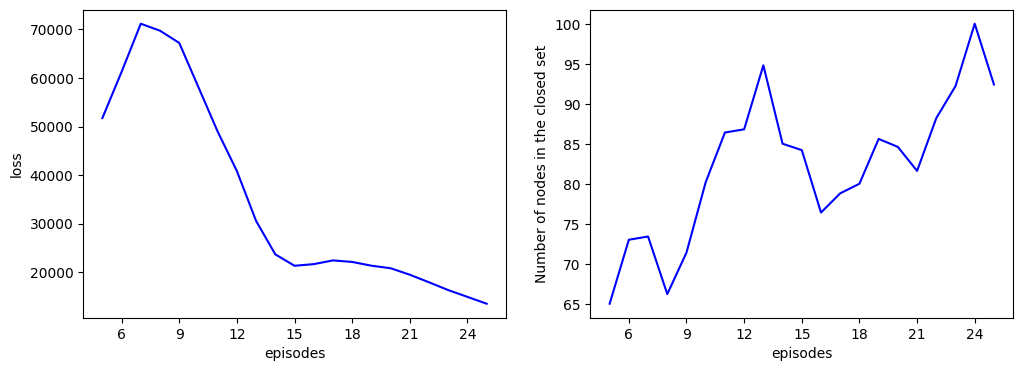

Episode 25, loss 1.128e+04, 5-epi-loss 1.351e+04 +- 1.91e+03, length 92 +- 34
Working on graph: 204, training...

SystemError: ignored

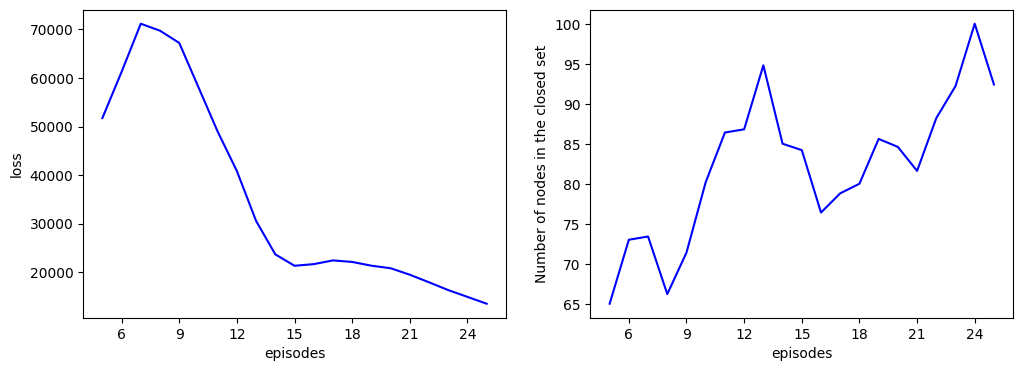

In [29]:
alternating_gaps_experiment_path = experiment_path / f'alternating_gaps_{device}.pickle'
alternating_gaps_experiment = new_experiment(alternating_gaps_train, device)

if alternating_gaps_experiment_path.exists():
    alternating_gaps_experiment.load(alternating_gaps_experiment_path)

# Re-executing this code-block picks up the experiment where you left off
try:
    alternating_gaps_experiment.run(alternating_gaps_train)
    alternating_gaps_experiment.save(alternating_gaps_experiment_path)
except KeyboardInterrupt:
    alternating_gaps_experiment.close()
    alternating_gaps_experiment.plot_training()

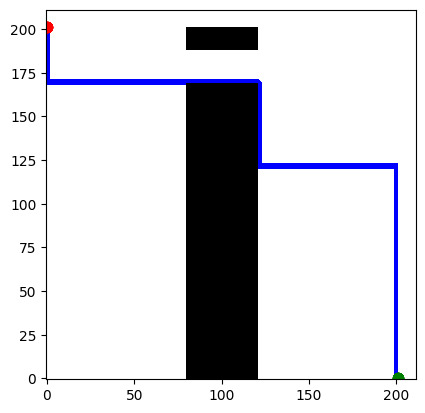

Graph 9, nodes evaluated 956.5 +- 0.5
[957, 957, 956, 957, 956, 956, 956, 957, 957, 956]


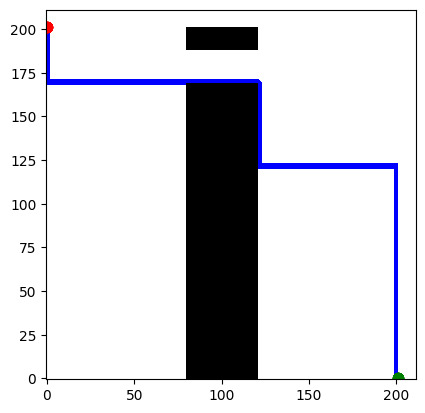

In [50]:
evaluator = ModelEvaluator(default_parameters(), device)
alternating_gaps_test_results = evaluator.evaluate(
    alternating_gaps_experiment.get_best_model(alternating_gaps_test),
    alternating_gaps_test[:10]
)
print(alternating_gaps_test_results)

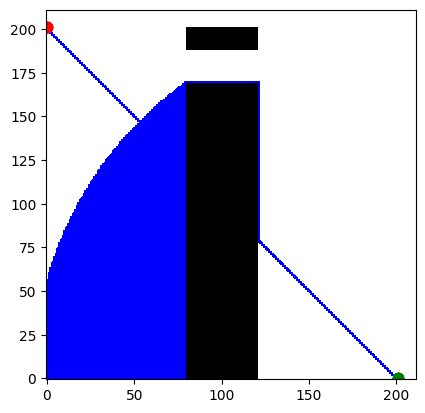

Graph 9, nodes evaluated 4795 +- 4.49e+03
[401, 401, 7343, 401, 10654, 7999, 9419, 401, 401, 10533]


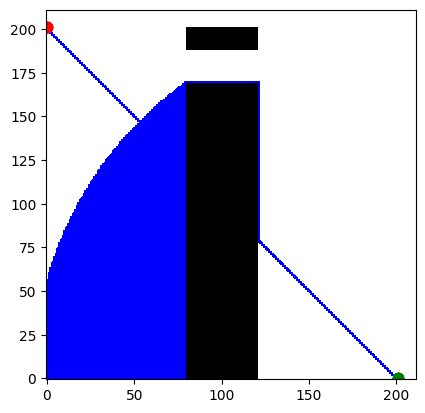

In [45]:
evaluator = ModelEvaluator(default_parameters(), device)
alternating_gaps_astar_test_results = evaluator.evaluate_a_star(
    alternating_gaps_test[:10]
)
print(alternating_gaps_astar_test_results)

In [57]:
def compare_two_results(a_star_res: list, gnn_res: list):
  """Helper method to compare the results of two different runs.
  
  Mainly shows the individual results, then the mean and the variance"""
  temp = np.array(gnn_res)/np.array(a_star_res)

  print(temp)

  print('Mean of res is: ', temp.mean())
  print('Std. of res is: ', temp.std())

compare_two_results(alternating_gaps_astar_test_results, alternating_gaps_test_results)


[2.38653367 2.38653367 0.13019202 2.38653367 0.08973156 0.11951494
 0.10149697 2.38653367 2.38653367 0.09076237]
Mean of res is:  1.2464366184476743
Std. of res is:  1.1401533769838197


In [59]:
alternating_gaps_experiment = None
gc.collect()

4527

### Bugtrap forest

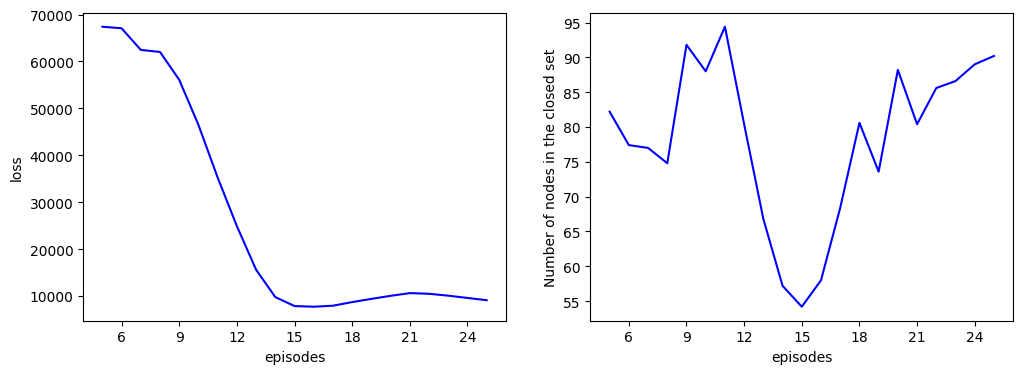

Episode 25, loss 8140, 5-epi-loss 9104 +- 596, length 90 +- 29
Working on graph: 58, training...

SystemError: ignored

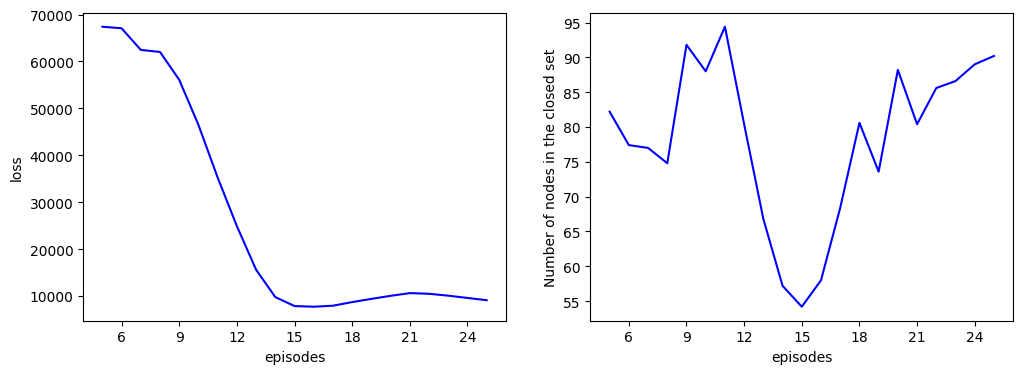

In [60]:
bugtrap_forest_experiment_path = experiment_path / f'bugtrap_forest_{device}.pickle'
bugtrap_forest_experiment = new_experiment(bugtrap_forest_train, device)

if bugtrap_forest_experiment_path.exists():
    bugtrap_forest_experiment.load(bugtrap_forest_experiment_path)

# Re-executing this code-block picks up the experiment where you left off
try:
    bugtrap_forest_experiment.run(bugtrap_forest_train)
    bugtrap_forest_experiment.save(bugtrap_forest_experiment_path)
except KeyboardInterrupt:
    bugtrap_forest_experiment.close()
    bugtrap_forest_experiment.plot_training()

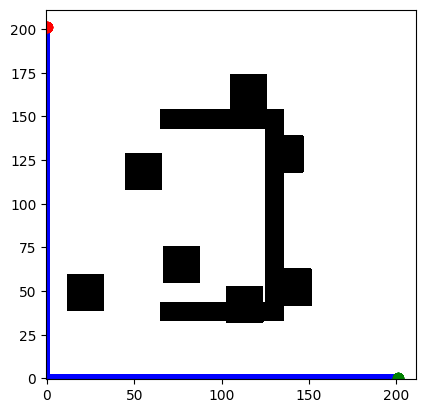

Graph 9, nodes evaluated 990.9 +- 21.3
[998, 998, 998, 998, 998, 927, 998, 998, 998, 998]


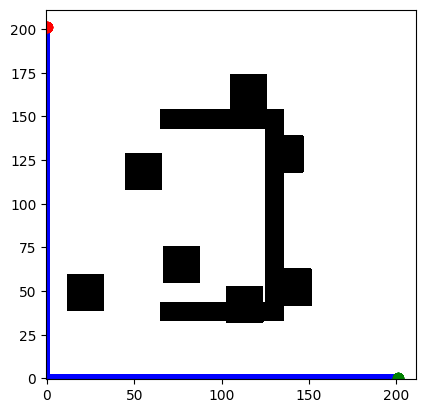

In [61]:
evaluator = ModelEvaluator(default_parameters(), device)
bugtrap_forest_test_results = evaluator.evaluate(
    bugtrap_forest_experiment.get_best_model(bugtrap_forest_test),
    bugtrap_forest_test[:10]
)
print(bugtrap_forest_test_results)

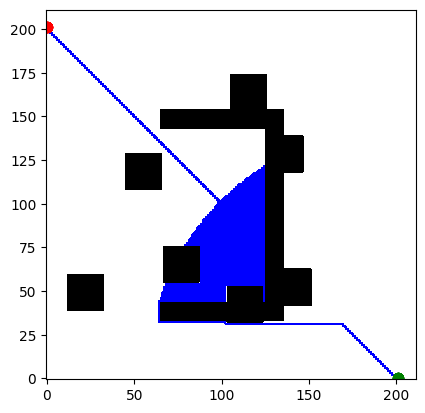

Graph 9, nodes evaluated 2584 +- 1.35e+03
[4083, 3069, 2498, 2645, 2001, 401, 2934, 401, 4985, 2828]


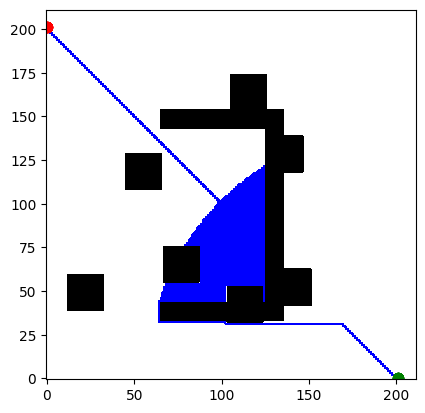

In [62]:
evaluator = ModelEvaluator(default_parameters(), device)
bugtrap_forest_test_results_a_star = evaluator.evaluate_a_star(
    bugtrap_forest_test[:10]
)
print(bugtrap_forest_test_results_a_star)

In [63]:
compare_two_results(bugtrap_forest_test_results_a_star, bugtrap_forest_test_results)

[0.24442812 0.32518736 0.39951962 0.37731569 0.49875062 2.3117207
 0.34014997 2.48877805 0.2002006  0.35289958]
Mean of res is:  0.7538950300898988
Std. of res is:  0.8277100446666626


In [65]:
bugtrap_forest_experiment = None
gc.collect()

56

### Gaps and forest

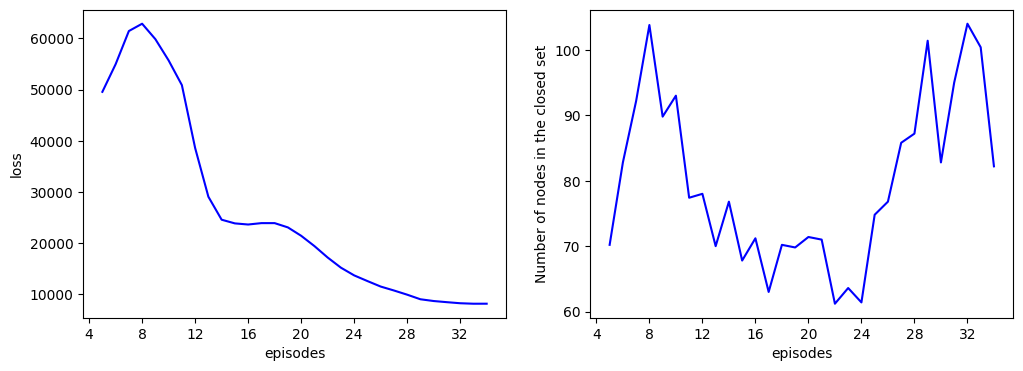

Episode 34, loss 7291, 5-epi-loss 8196 +- 713, length 82 +- 41
Stopped early after 34 iterations.


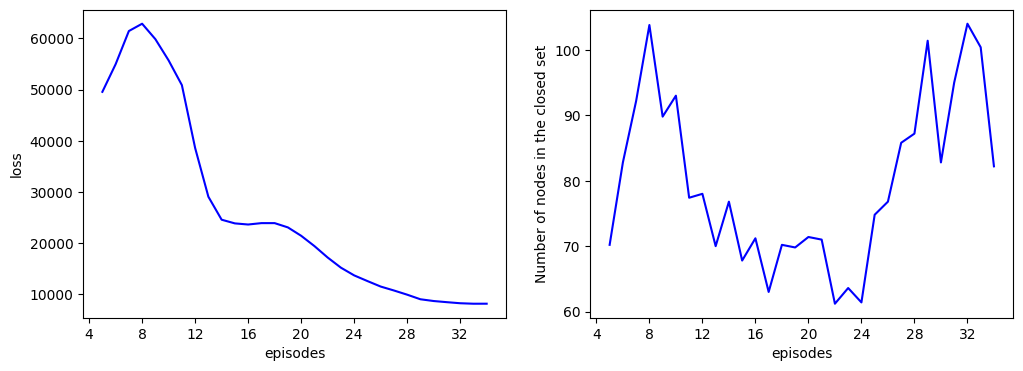

In [66]:
gaps_and_forest_experiment_path = experiment_path / f'gaps_and_forest_{device}.pickle'
gaps_and_forest_experiment = new_experiment(gaps_and_forest_train, device)

if gaps_and_forest_experiment_path.exists():
    gaps_and_forest_experiment.load(gaps_and_forest_experiment_path)

# Re-executing this code-block picks up the experiment where you left off
try:
    gaps_and_forest_experiment.run(gaps_and_forest_train)
    gaps_and_forest_experiment.save(gaps_and_forest_experiment_path)
except KeyboardInterrupt:
    gaps_and_forest_experiment.close()
    gaps_and_forest_experiment.plot_training()

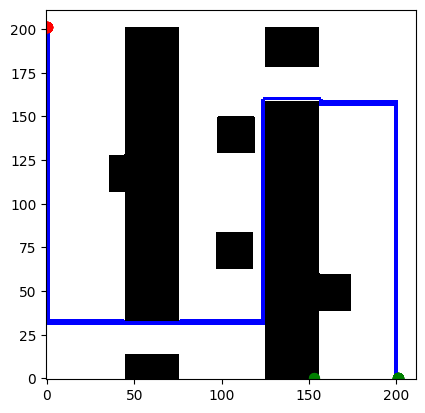

Graph 9, nodes evaluated 1307 +- 312
[1322, 1412, 1329, 1375, 1437, 1529, 388, 1434, 1404, 1442]


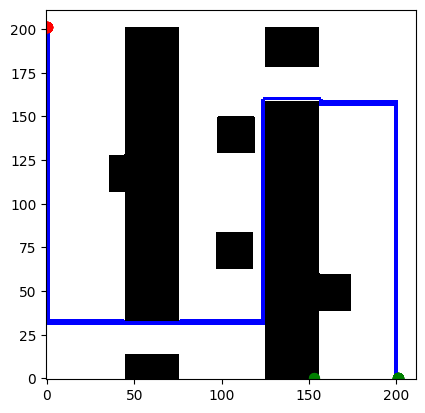

In [67]:
evaluator = ModelEvaluator(default_parameters(), device)
gaps_and_forest_results = evaluator.evaluate(
    gaps_and_forest_experiment.get_best_model(gaps_and_forest_test),
    gaps_and_forest_test[:10]
)
print(gaps_and_forest_results)

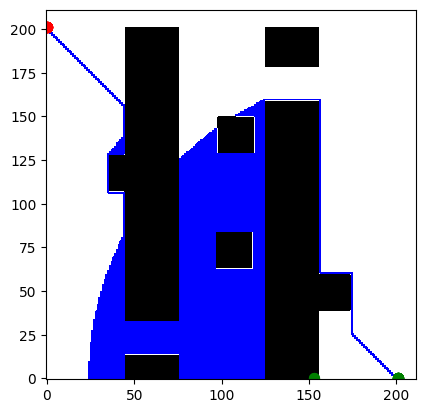

Graph 9, nodes evaluated 7764 +- 2.79e+03
[5907, 9930, 10225, 8149, 9226, 8202, 197, 7706, 9653, 8448]


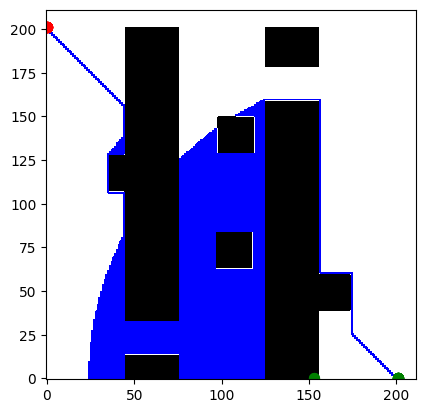

In [68]:
evaluator = ModelEvaluator(default_parameters(), device)
gaps_and_forest_results_a_star = evaluator.evaluate_a_star(
    gaps_and_forest_test[:10]
)
print(gaps_and_forest_results_a_star)

In [69]:
compare_two_results(gaps_and_forest_results_a_star, gaps_and_forest_results)

[0.22380227 0.14219537 0.12997555 0.16873236 0.15575547 0.18641795
 1.96954315 0.18608876 0.14544701 0.17069129]
Mean of res is:  0.347864917487501
Std. of res is:  0.5411656147631733


In [70]:
gaps_and_forest_experiment = None
gc.collect()

32713